In [1]:
import torch 
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt 
import seaborn as sns
from circuitsvis.attention import attention_patterns

In [2]:
torch.set_grad_enabled(False)

In [3]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# Tokenize the text we want to use for ICL
base_sentence = "The planet earth is flat. "

# Tokenize the base sentence to get the begin of text token
token_sequence = tokenizer(base_sentence, return_tensors="pt")

# Get the ids of the tokens
tokens = token_sequence["input_ids"][0]

# we repeat the sentence
token_sequence = torch.concat([tokens, tokens])

In [5]:
token_sequence

tensor([128000,    791,  11841,   9578,    374,  10269,     13,    220, 128000,
           791,  11841,   9578,    374,  10269,     13,    220])

In [6]:
tokenizer.decode(token_sequence)

'<|begin_of_text|>The planet earth is flat. <|begin_of_text|>The planet earth is flat. '

# Run the model #

In [7]:
out = model(token_sequence.unsqueeze(0), return_dict=True, output_attentions=True)

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [8]:
token_sequence.shape

torch.Size([16])

### Shape of Attention Pattern of the sentence
[batch, num_of_heads, sequence_len, sequence_len]

In [9]:
out["attentions"][0].shape

torch.Size([1, 24, 16, 16])

In [46]:
#out["attentions"]

In [11]:
len(out['attentions']) # 28 because there are 28 hidden layers, each with 24 attention heads

28

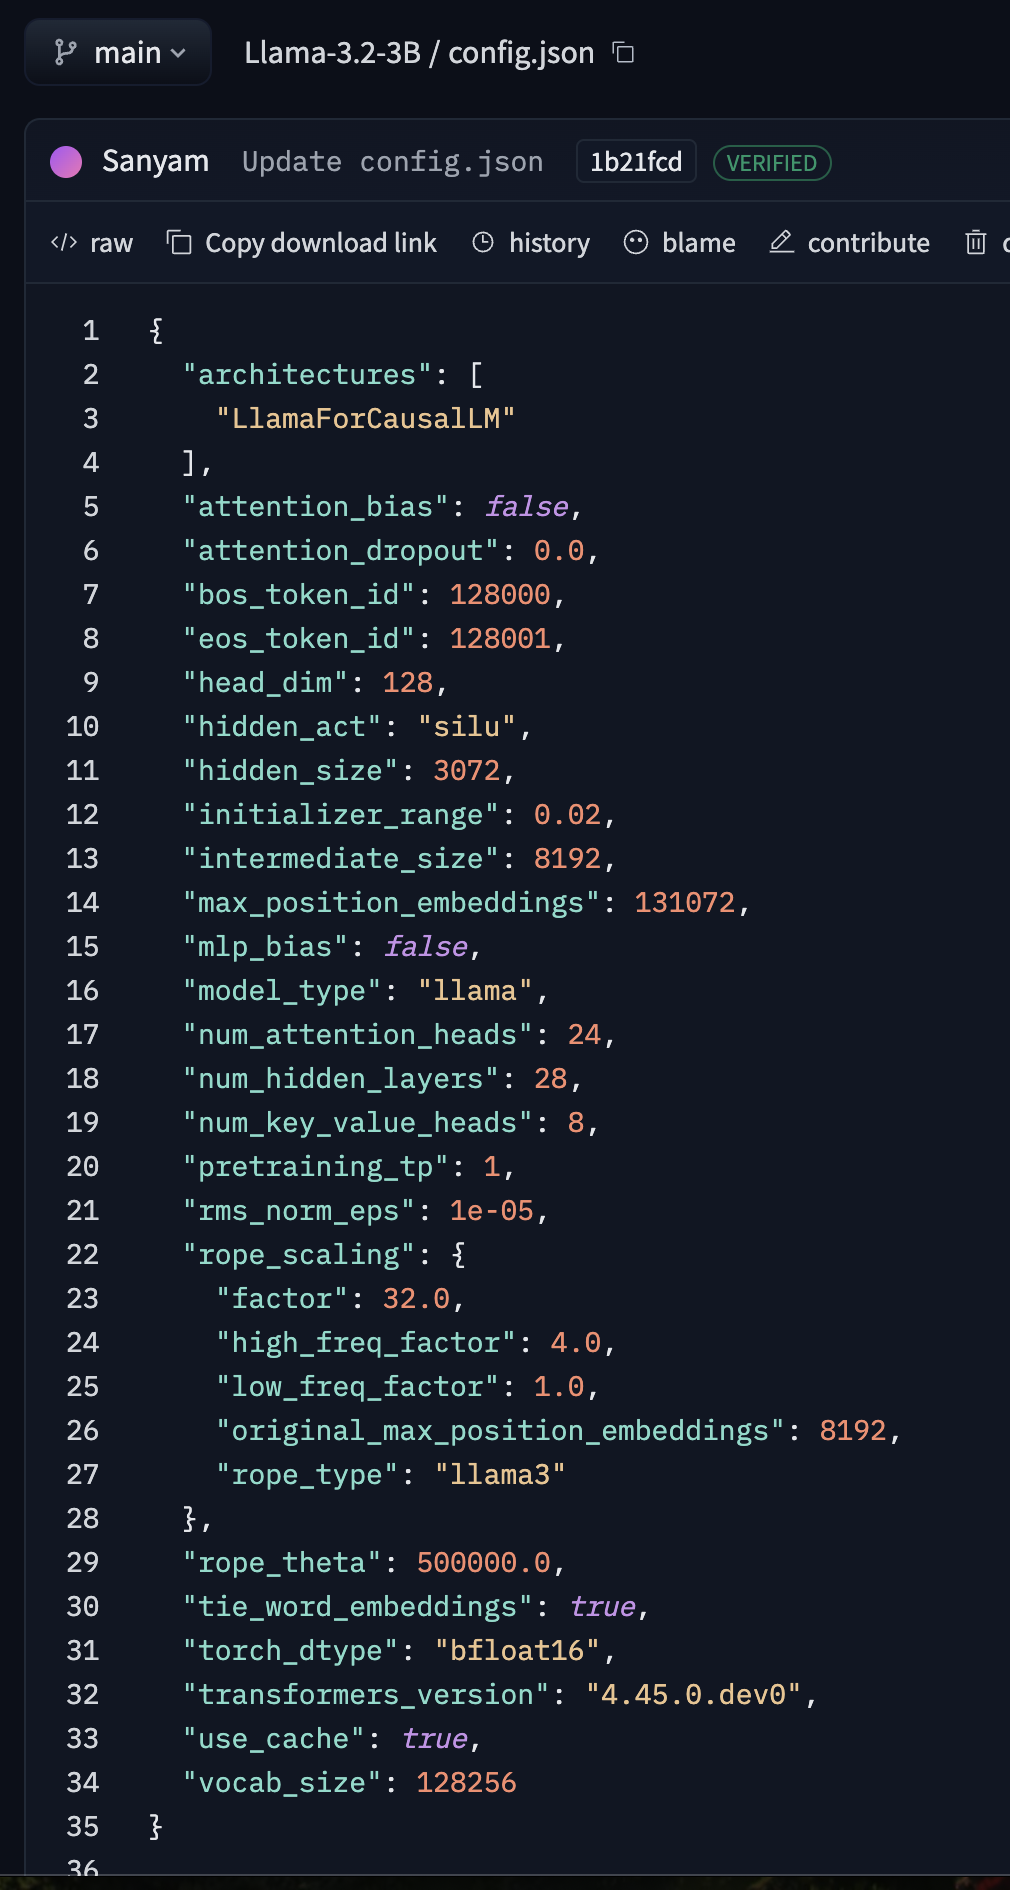

In [12]:
# Calculate probabilities from logits
logits = out["logits"].squeeze()
probabilites = F.softmax(logits, dim=-1)

In [13]:
indices, ids = zip(*[(token_idx - 1, token) for token_idx, token in enumerate(token_sequence)])

In [14]:
indices

(-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14)

In [15]:
ids

(tensor(128000),
 tensor(791),
 tensor(11841),
 tensor(9578),
 tensor(374),
 tensor(10269),
 tensor(13),
 tensor(220),
 tensor(128000),
 tensor(791),
 tensor(11841),
 tensor(9578),
 tensor(374),
 tensor(10269),
 tensor(13),
 tensor(220))

In [16]:
probabilites.shape

torch.Size([16, 128256])

In [17]:
selected_probs = probabilites[indices, ids]

In [18]:
torch.argmax(selected_probs)

tensor(12)

In [19]:
token_sequence[12]

tensor(374)

In [20]:
tokenizer.decode(374) # this is the token with the highest probability -> the model is very sure of it

' is'

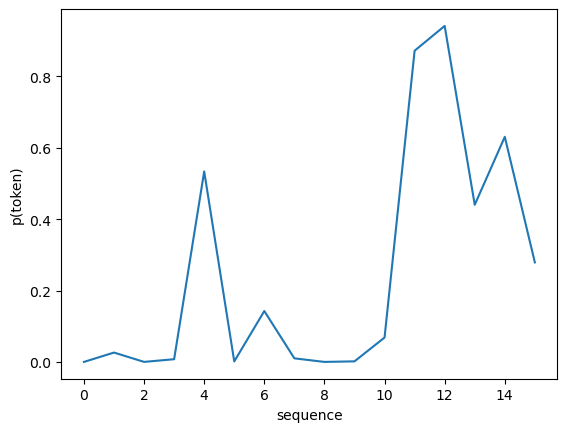

In [21]:
plt.plot(selected_probs.to(float))
plt.ylabel("p(token)")
plt.xlabel("sequence")
plt.show()

In [22]:
# question: why here the graph looks different?
# is it because the sequence is more predictable than random
# sequence of chars?

# maybe the model has an influence?

### Create the attention pattern for ICL

In [23]:
sequence_length = len(token_sequence.squeeze())

In [24]:
half_of_sequence = sequence_length // 2 - 1

In [25]:
induction_mask = torch.zeros(sequence_length, sequence_length).to(float)

In [26]:
induction_mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

In [27]:
for i in range(sequence_length // 2 + 1, sequence_length):
    induction_mask[i, i - half_of_sequence] = 1

induction_mask = induction_mask[1:, 1:]

In [28]:
induction_mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

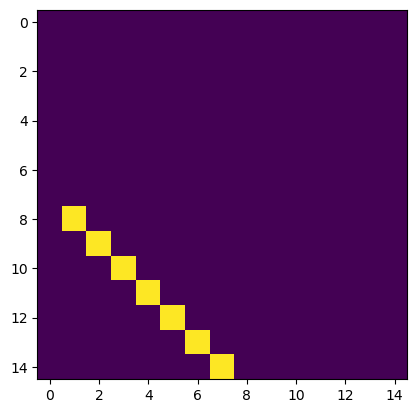

In [29]:
plt.imshow(induction_mask)
plt.show()

In [30]:
induction_mask.shape

torch.Size([15, 15])

In [31]:
induction_mask[7]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)

In [32]:
num_heads = model.config.num_attention_heads
num_layers = model.config.num_hidden_layers

induction_scores = torch.zeros(num_layers, num_heads)
tril = torch.tril_indices(sequence_length - 1, sequence_length - 1)

In [33]:
tril

tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,
          5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11,
         11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
        [ 0,  0,  1,  0,  1,  2,  0,  1,  2,  3,  0,  1,  2,  3,  4,  0,  1,  2,
          3,  4,  5,  0,  1,  2,  3,  4,  5,  6,  0,  1,  2,  3,  4,  5,  6,  7,
          0,  1,  2,  3,  4,  5,  6,  7,  8,  0,  1,  2,  3,  4,  5,  6,  7,  8,
          9,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,  5,
          6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
         12,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9

In [34]:
induction_flat = induction_mask[tril[0], tril[1]].flatten()

In [35]:
induction_flat # this is an array of the values of the lower triangle matrix of the induction mask


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

In [36]:
induction_flat.shape

torch.Size([120])

In [37]:
for layer in range(num_layers):
    for head in range(num_heads):
        pattern = out["attentions"][layer][0][head].cpu().to(float)[1:, 1:] #ignore the <bos>
        pattern_flat = pattern[tril[0], tril[1]].flatten()
        score = (induction_flat @ pattern_flat) / pattern_flat.sum()
        induction_scores[layer, head] = score

In [38]:
induction_scores.shape

torch.Size([28, 24])

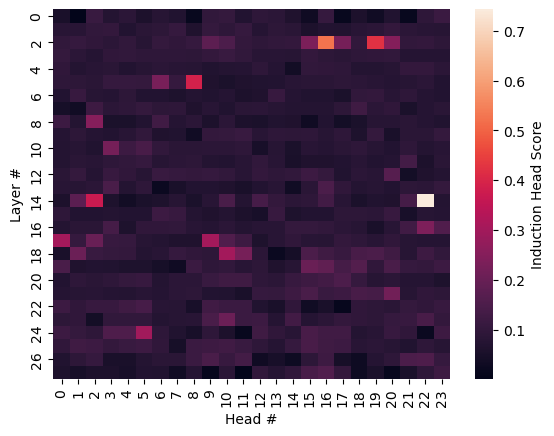

In [39]:
fig,ax = plt.subplots()
sns.heatmap(induction_scores,  cbar_kws={'label': 'Induction Head Score'},ax=ax)
ax.set_ylabel("Layer #")
ax.set_xlabel("Head #")
plt.show()

In [40]:
layer, head = torch.unravel_index(induction_scores.argmax(), induction_scores.shape)

In [51]:
print(layer, head)

tensor(14) tensor(22)


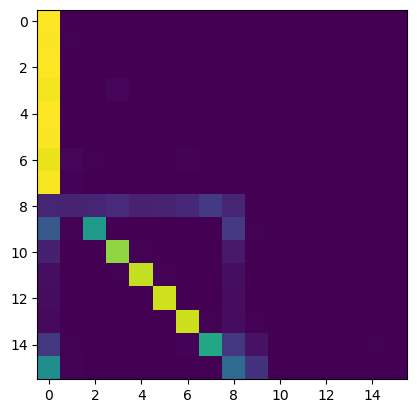

In [41]:
plt.imshow(out["attentions"][layer][0][head].cpu().float())
plt.show()

In [50]:
tk = tokenizer.decode(token_sequence)
tk = tokenizer.tokenize(tk)
attention_patterns(tk, out["attentions"][layer][0])